# IBM Data Science Professional Certification Capstone

### The Battle of (Budapest) Neighborhoods

In this Notebook, I will conduct a study about the different ZIP code areas in the city of Budapest. I will attempt to cluster the different areas into similar clusters that share characteristics. To accomplish that, I will use the K-Means algorithm for clustering.

My motivation to do this study is two-fold: first, this will be the Capstone Project of the IBM Data Science Professional Certificate, and second, I have a personal interest, because at the time of writing, I am considering moving to another house.


Disclaimer: Some of the code in this Notebook is adaptted from the lectures of the IBM Data Science Professional Certificate.

Let's import the required Packages and Libraries.

In [75]:
import pandas as pd
import numpy as np
import random
from sklearn.cluster import KMeans

import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from io import StringIO

from arcgis.gis import GIS
from arcgis.geocoding import geocode

!pip -q install folium
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

Let's get the data regarding ZIP codes in Budapest. I've uploaded a .csv file in my personanl Google Drive. Original source is listed below.  
https://www.posta.hu/szolgaltatasok/iranyitoszam-kereso  

In [76]:
orig_url='https://drive.google.com/file/d/1EoL1qB5NpDGlcTV3-X2Kn-1xVExiLYEI/edit'

file_id = orig_url.split('/')[-2]
download_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(download_url).text
raw_csv = StringIO(url)
BP_postalCodes = pd.read_csv(raw_csv)

BP_postalCodes.drop(BP_postalCodes.columns[[1,2,3,4,5,6]], inplace=True, axis=1)
BP_postalCodes.drop([0], inplace=True)
BP_postalCodes.reset_index(drop=True, inplace=True)
BP_postalCodes.columns = ['PostalCode', 'District']
BP_postalCodes.head()


,PostalCode,District
0,1011,I.
1,1012,I.
2,1013,I.
3,1014,I.
4,1015,I.


Let's get the Latitudes and Longitudes for each Postal Code using the ArcGIS library.

In [77]:
gis = GIS()

#Empty Latitude and Longitude lists that will become the columns to our table with the same name
latitude_list = []
longitude_list = []

#Go through each row of the Table and add information on Latitude and Longitude for each address
for index, row in BP_postalCodes.iterrows():
    geocode_result = geocode(address=f'{row.PostalCode} Budapest', as_featureset=False)
    latitude_list.append(geocode_result[0]['location']['y'])
    longitude_list.append(geocode_result[0]['location']['x'])
    
BP_postalCodes['Latitude'] = latitude_list
BP_postalCodes['Longitude'] = longitude_list


Now, let's draw a map to see where the Budapest ZIP code areas are.  

In [78]:
budapest_lat = 0
budapest_long = 0

geocode_result = geocode(address = 'Budapest', as_featureset=False)
budapest_lat = geocode_result[0]['location']['y']
budapest_long = geocode_result[0]['location']['x']

bp_map = folium.Map(location=[budapest_lat, budapest_long], zoom_start=12)

folium.CircleMarker(
    [budapest_lat, budapest_long],
    radius=5,
    popup='Budapest',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(bp_map)
    
# add popular spots to the map as blue circle markers
for lat, lng, district, postcode in zip(BP_postalCodes.Latitude, BP_postalCodes.Longitude, BP_postalCodes.District, BP_postalCodes.PostalCode):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=f'{district} {postcode}',
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(bp_map)

# display map
bp_map

Next, let's get extra details for each district from Foursquare.

In [82]:
#Foursquare API credentials. Removed for sharing in GitHub
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605' # Foursquare API version
LIMIT = 100
RADIUS = 500

In [83]:
def getNearbyVenues(names, latitudes, longitudes, radius=RADIUS):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [84]:
df_bp_venues = getNearbyVenues(names=BP_postalCodes['PostalCode'], latitudes=BP_postalCodes['Latitude'], longitudes=BP_postalCodes['Longitude'])
df_bp_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1011,47.511766,19.035662,Ganz Söröző,47.511014,19.037386,Beer Bar
1,1011,47.511766,19.035662,Bagett Mechwart,47.511228,19.032691,Breakfast Spot
2,1011,47.511766,19.035662,Bandha Works Jógaiskola,47.512983,19.037812,Yoga Studio
3,1011,47.511766,19.035662,Bambi Eszpresszó,47.512452,19.037885,Café
4,1011,47.511766,19.035662,Pivohalle Sörvendéglő,47.513792,19.036463,Beer Bar


In the next step, let's process the places of relevance in Budapest to have only normalized scalar data.

In [85]:
# one hot encoding
df_bp_onehot = pd.get_dummies(df_bp_venues[['Venue Category']], prefix="", prefix_sep="")

# add the 'District' column to the dataframe
df_bp_onehot['PostalCode'] = df_bp_venues['PostalCode'] 

# move neighborhood column to the first column
fixed_columns = [df_bp_onehot.columns[-1]] + list(df_bp_onehot.columns[:-1])
df_bp_onehot = df_bp_onehot[fixed_columns]

#Get the frequency for each Value Category
df_bp_grouped = df_bp_onehot.groupby('PostalCode').mean().reset_index()

In [86]:
df_bp_grouped.head()

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,1011,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.011364,0.0,0.0,0.011364,0.000000,0.0,0.022727,0.0,0.0
1,1012,0.0,0.0,0.0,0.0,0.0,0.0,0.019608,0.000000,0.000000,...,0.0,0.019608,0.0,0.0,0.019608,0.000000,0.0,0.000000,0.0,0.0
2,1013,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.026316,0.000000,...,0.0,0.000000,0.0,0.0,0.026316,0.026316,0.0,0.000000,0.0,0.0
3,1014,0.0,0.0,0.0,0.0,0.0,0.0,0.012987,0.000000,0.012987,...,0.0,0.012987,0.0,0.0,0.025974,0.000000,0.0,0.000000,0.0,0.0
4,1015,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.033898,0.000000,0.0,0.000000,0.0,0.0


Now, let's create a table with the Top10 places in each Postal Code.

In [87]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In the following lines, let's explore different configurations for the K-Means algorithm and plot the Distortion as a funciton of number of clusters (k).

In [88]:
df_bp_grouped_clustering = df_bp_grouped.drop('PostalCode', 1)
df_bp_grouped_clustering.head()

distortions = []
for k in range(1,50):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_bp_grouped_clustering)
    distortions.append(kmeans.inertia_)


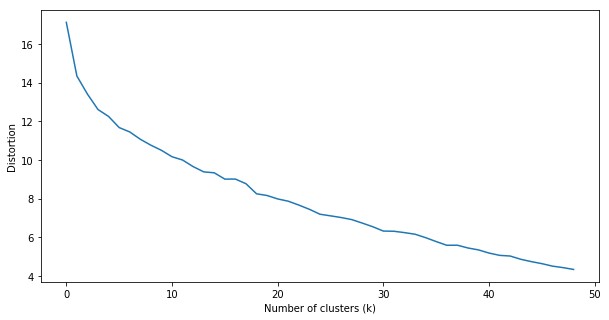

In [89]:
plt.figure(figsize=(10,5))
plt.plot(distortions)
plt.ylabel('Distortion')
plt.xlabel('Number of clusters (k)')
plt.show()

According to the chart, there seems to be an 'elbow' in the region around 8 clusters. However, when plotting in the map, the resulting clustering, there's a bunch of dots with the same colour in Budapest city center. This doesn't give too much information about that areas, so let's increase the number of clusters, to have more information about that area. After different tries, it seems a number of 50 clusters provide a good separation of ZIP code areas in the city center.

In [90]:
# set number of clusters
kclusters = 50

df_bp_grouped_clustering = df_bp_grouped.drop('PostalCode', 1)
df_bp_grouped_clustering.head()
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_bp_grouped_clustering)


Now, let's figure out which are the top venues for each ZIP code area.

In [91]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
pcs_venues_sorted = pd.DataFrame(columns=columns)
pcs_venues_sorted['PostalCode'] = df_bp_grouped['PostalCode']

for ind in np.arange(df_bp_grouped.shape[0]):
    pcs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_bp_grouped.iloc[ind, :], num_top_venues)

pcs_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1011,Breakfast Spot,Bar,Hotel,Café,Bakery,Restaurant,Park,Beer Bar,Coffee Shop,Spa
1,1012,Restaurant,Hungarian Restaurant,Café,Park,Hotel,Bakery,History Museum,Coffee Shop,Italian Restaurant,Grocery Store
2,1013,Hungarian Restaurant,Park,Scenic Lookout,Sculpture Garden,Plaza,Café,History Museum,Historic Site,Lounge,Gym / Fitness Center
3,1014,Café,Hungarian Restaurant,Hotel,Restaurant,Historic Site,Park,Coffee Shop,Italian Restaurant,Plaza,Scenic Lookout
4,1015,Hungarian Restaurant,Hotel,Café,Historic Site,Bakery,Restaurant,Coffee Shop,Bar,Pub,Plaza


In [92]:
# add clustering labels
pcs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#pcs_venues_sorted.info()

#df_bp_merged = BP_postalCodes
df_bp_merged = pcs_venues_sorted

# merge Budapest Clustered and Ranked data with Budapest data to add latitude/longitude for each neighborhood
#df_bp_merged = df_bp_merged.join(pcs_venues_sorted.set_index('PostalCode'), on='PostalCode')
df_bp_merged = df_bp_merged.join(BP_postalCodes.set_index('PostalCode'), on='PostalCode')

df_bp_merged.head()

,Cluster Labels,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
0,0,1011,Breakfast Spot,Bar,Hotel,Café,Bakery,Restaurant,Park,Beer Bar,Coffee Shop,Spa,I.,47.511766,19.035662
1,35,1012,Restaurant,Hungarian Restaurant,Café,Park,Hotel,Bakery,History Museum,Coffee Shop,Italian Restaurant,Grocery Store,I.,47.501720,19.028845
2,35,1013,Hungarian Restaurant,Park,Scenic Lookout,Sculpture Garden,Plaza,Café,History Museum,Historic Site,Lounge,Gym / Fitness Center,I.,47.493500,19.041297
3,35,1014,Café,Hungarian Restaurant,Hotel,Restaurant,Historic Site,Park,Coffee Shop,Italian Restaurant,Plaza,Scenic Lookout,I.,47.502045,19.032255
4,35,1015,Hungarian Restaurant,Hotel,Café,Historic Site,Bakery,Restaurant,Coffee Shop,Bar,Pub,Plaza,I.,47.503970,19.035104


And let's plot the results of the K-Means algorithm in a map of the city, with color coding to differentiate between clusters.

In [106]:
# create map
bp_map_clusters = folium.Map(location=[budapest_lat, budapest_long], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
random.shuffle(rainbow) # sometimes clusters geographically close to each other get assigned very similar colors, so it's necessary to shuffle the color palette

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_bp_merged['Latitude'], df_bp_merged['Longitude'], df_bp_merged['PostalCode'], df_bp_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bp_map_clusters)
       
bp_map_clusters

Let's check which are the clusters that agregate more postal codes, i.e. what are the most common types of postal codes.

In [107]:
top_cluster_num = 10
df_bp_merged['Cluster Labels'].value_counts().head(top_cluster_num)

0     30
6     24
48    24
35     8
19     6
9      5
3      4
45     4
31     3
15     3
Name: Cluster Labels, dtype: int64

Seems about half of Postal Codes are of cluster type 0, 6, and 48. Let's understand better what each type of cluster is.  
NOTE: if you re-run this code at a later date, you will probably get different clustering and numbers. That's becasue point of interest data from Foursquare is constantly evolving, and so will the caracteristics of each ZIP/Postal code area.

In [108]:
df_cluster_eval = pd.DataFrame(kmeans.cluster_centers_)
df_cluster_eval.columns = df_bp_grouped.columns[1:]

eval_list= df_bp_merged['Cluster Labels'].value_counts().head(top_cluster_num)

for cluster_type,pc_count in eval_list.iteritems():
    print(f'Top places for cluster {cluster_type}:')
    print(f'(Contains {pc_count} Postal Codes)\n')
    print(df_cluster_eval.T[cluster_type].nlargest(10))
    print('\n\n')

Top places for cluster 0:
(Contains 30 Postal Codes)

Bar                     0.052742
Hotel                   0.051390
Coffee Shop             0.050092
Bakery                  0.030627
Restaurant              0.029958
Café                    0.028768
Pub                     0.027506
Hungarian Restaurant    0.025718
Plaza                   0.023884
Italian Restaurant      0.021828
Name: 0, dtype: float64



Top places for cluster 6:
(Contains 24 Postal Codes)

Bus Stop                0.079894
Park                    0.051135
Grocery Store           0.045194
Bakery                  0.043447
Tram Station            0.042939
Dessert Shop            0.029517
Gym / Fitness Center    0.028355
Plaza                   0.027071
Electronics Store       0.022224
Bus Station             0.020153
Name: 6, dtype: float64



Top places for cluster 48:
(Contains 24 Postal Codes)

Coffee Shop             0.050741
Bakery                  0.031465
Dessert Shop            0.027840
Café                    

The numbers above show the top 10 types of points of interest that are more popular in the aforementioned clusters. For instance, there seems to be a lot of Bus Stops in ZIP code areas associated with cluster 6 (Royal Blue color in the 50 cluster map), so if access to public transportation is important to you, you might want to consider living in such a ZIP code area.  

On the other hand, ZIP code areas in cluster 9 (Dodger Blue color in the 50 cluster map) seem to be a good balance between Bars, Gyms, Hotels, Train Stations, and Tram Stations.


Finaly, let's draw only the top Clusters

In [96]:
# create map
bp_map_top_clusters = folium.Map(location=[budapest_lat, budapest_long], zoom_start=13)

# set color scheme for the clusters

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

top_cluster_list = df_bp_merged['Cluster Labels'].value_counts().head(top_cluster_num).index
df_bp_merged_top_clust = df_bp_merged[df_bp_merged['Cluster Labels'].isin(top_cluster_list)]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_bp_merged_top_clust['Latitude'],
                                  df_bp_merged_top_clust['Longitude'],
                                  df_bp_merged_top_clust['PostalCode'],
                                  df_bp_merged_top_clust['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bp_map_top_clusters)
       
bp_map_top_clusters

Thank you for reading until the end!  
José Fernandes